# Lesson 3 - Cross-Validation



## Lesson Video: 

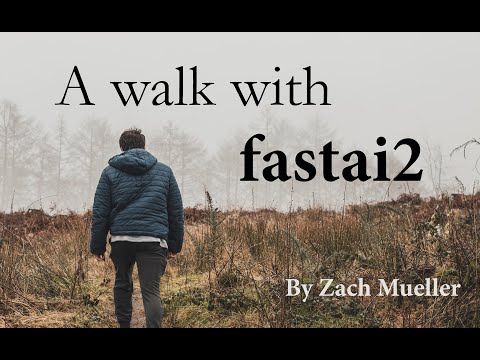

In [ ]:
#hide_input
from IPython.lib.display import YouTubeVideo
from datetime import timedelta
start = int(timedelta(minutes=35, seconds=3).total_seconds())
YouTubeVideo('pQ7CJzGn6YE', start=start)

In [ ]:
#hide
#Run once per session
!pip install fastai wwf -q --upgrade

In [ ]:
#hide_input
from wwf.utils import state_versions
state_versions(['fastai', 'fastcore', 'wwf'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, and `wwf` currently running at the time of writing this:
* `fastai`: 2.2.7 
* `fastcore`: 1.3.19 
* `wwf`: 0.0.13 
---

## What is K-Fold Cross Validation?

* A way to get the most out of your data
* More models
* Ensembling
* Requires more training 

## What is needed?

* Training set
* Test set

* Why no validation?

## Importing the Library

We will be doing a vision task so we'll import the vision library

In [ ]:
from fastai.vision.all import *

Below you will find the exact imports for everything we use today

In [ ]:
from fastcore.foundation import L

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import fit_one_cycle

from fastai.data.core import Datasets, show_at
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import IntToFloatTensor, Normalize, ToTensor, IndexSplitter, get_image_files, parent_label, Categorize

from fastai.metrics import accuracy

from fastai.vision.augment import aug_transforms, RandomResizedCrop
from fastai.vision.core import PILImage, imagenet_stats
from fastai.vision.learner import cnn_learner

import random

from sklearn.model_selection import StratifiedKFold

from torchvision.models.resnet import resnet34

## ImageWoof

In [ ]:
path = untar_data(URLs.IMAGEWOOF)

In [ ]:
path.ls()

(#3) [Path('/home/frank/.fastai/data/imagewoof2/noisy_imagewoof.csv'),Path('/home/frank/.fastai/data/imagewoof2/val'),Path('/home/frank/.fastai/data/imagewoof2/train')]

Scenario:

* We have a training set
* We have a test set

In [ ]:
item_tfms = [ToTensor(), RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))]
batch_tfms = [IntToFloatTensor(), *aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=64

We'll use the `IndexSplitter` just to get to know it. What we really wind up doing is a `RandomSplitter` split 80/20.

We can see `IndexSplitter`'s source code by doing:

In [ ]:
IndexSplitter??

Signature: IndexSplitter(valid_idx)
Source:   
def IndexSplitter(valid_idx):
    "Split `items` so that `val_idx` are in the validation set and the others in the training set"
    def _inner(o):
        train_idx = np.setdiff1d(np.array(range_of(o)), np.array(valid_idx))
        return L(train_idx, use_list=True), L(valid_idx, use_list=True)
    return _inner
File:      ~/miniconda3/envs/learn/lib/python3.8/site-packages/fastai/data/transforms.py
Type:      function


Next let's get our images

In [ ]:
train_imgs = get_image_files(path/'train')
tst_imgs = get_image_files(path/'val')

We'll shuffle up our training set so the chance of including all classes is almost guarenteed

In [ ]:
random.shuffle(train_imgs)

In [ ]:
len(train_imgs)

9025

And then we will do the 80/20 split

In [ ]:
train_imgs

(#9025) [Path('/home/frank/.fastai/data/imagewoof2/train/n02099601/n02099601_2397.JPEG'),Path('/home/frank/.fastai/data/imagewoof2/train/n02087394/n02087394_19836.JPEG'),Path('/home/frank/.fastai/data/imagewoof2/train/n02096294/n02096294_4424.JPEG'),Path('/home/frank/.fastai/data/imagewoof2/train/n02088364/n02088364_12385.JPEG'),Path('/home/frank/.fastai/data/imagewoof2/train/n02096294/n02096294_8436.JPEG'),Path('/home/frank/.fastai/data/imagewoof2/train/n02088364/ILSVRC2012_val_00020553.JPEG'),Path('/home/frank/.fastai/data/imagewoof2/train/n02115641/n02115641_8426.JPEG'),Path('/home/frank/.fastai/data/imagewoof2/train/n02086240/n02086240_5554.JPEG'),Path('/home/frank/.fastai/data/imagewoof2/train/n02093754/n02093754_5928.JPEG'),Path('/home/frank/.fastai/data/imagewoof2/train/n02115641/n02115641_11764.JPEG')...]

In [ ]:
start_val = len(train_imgs) - int(len(train_imgs)*.2)
idxs = list(range(start_val, len(train_imgs)))
splitter = IndexSplitter(idxs)
splits = splitter(train_imgs)

Since we want to include our test set in with these splits, we'll make a `split_list` of all three of our splits (train, valid, test)

In [ ]:
split_list = [splits[0], splits[1]]

And we'll add in the range for our test set here:

In [ ]:
split_list.append(L(range(len(train_imgs), len(train_imgs)+len(tst_imgs))))

In [ ]:
split_list

[(#7220) [0,1,2,3,4,5,6,7,8,9...],
 (#1805) [7220,7221,7222,7223,7224,7225,7226,7227,7228,7229...],
 (#3929) [9025,9026,9027,9028,9029,9030,9031,9032,9033,9034...]]

Let's check that everything worked as intended. First building the `Datasets`:

In [ ]:
dsrc = Datasets(train_imgs+tst_imgs, tfms=[[PILImage.create], [parent_label, Categorize]],
                splits = split_list)

We can look at an item:

<AxesSubplot:title={'center':'n02088364'}>

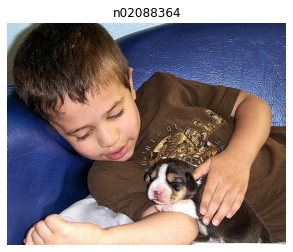

In [ ]:
show_at(dsrc.train, 3)

And if we check `n_subsets`, we can see that three are there (for our three splits)

In [ ]:
dsrc.n_subsets

3

Now let's build some `DataLoaders`

In [ ]:
dls = dsrc.dataloaders(bs=bs, after_item=item_tfms, after_batch=batch_tfms)

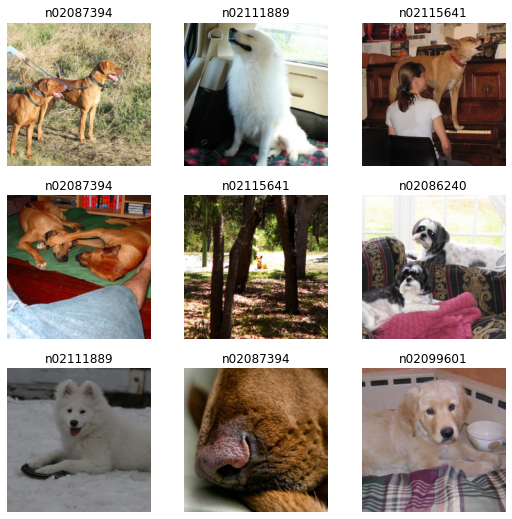

In [ ]:
dls.show_batch()

We can see the subsets was passed down to here as well:

In [ ]:
dls.n_subsets

3

What this means is while `dls.train` and `dls.valid` will return what we would expect, if we were to instead _index_ into our `DataLoader`, we can find our testing data in there too:

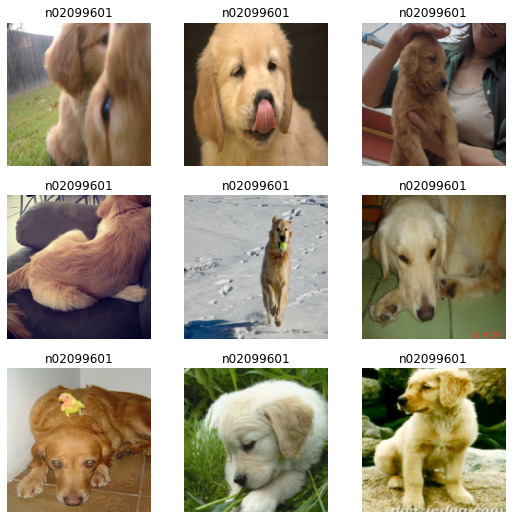

In [ ]:
dls[2].show_batch()

Let's do a quick baseline

In [ ]:
learn = cnn_learner(dls, resnet34, pretrained=False, metrics=accuracy).to_fp16()

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,2.760213,2.166512,0.221053,00:27


Now how do we check it?

We can run `learn.validate` on our subset

In [ ]:
learn.validate(ds_idx=2)

(#2) [2.1163723468780518,0.22881139814853668]

## Now **how** do I do Cross-Validation?

First let's import our KFold

In [ ]:
from sklearn.model_selection import StratifiedKFold

And grab all the labels from our dataset

In [ ]:
train_labels = L(dsrc.items).map(dsrc.tfms[1])

Now let's make our K-Fold

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

Finally we need to define a training loop to go over all our folds and gather our validation and test accuracy

In [ ]:
n_splits = 10

In [ ]:
import random
random.shuffle(train_imgs)

What's our loop going to look like?

In [ ]:
val_pct = []
tst_preds = []
skf = StratifiedKFold(n_splits=10, shuffle=True)
for _, val_idx in kf.split(np.array(train_imgs+tst_imgs), train_labels):
  splits = IndexSplitter(val_idx)
  split = splits(train_imgs)
  split_list = [split[0], split[1]]
  split_list.append(L(range(len(train_imgs), len(train_imgs)+len(tst_imgs))))
  dsrc = Datasets(train_imgs+tst_imgs, tfms=[[PILImage.create], [parent_label, Categorize]],
                  splits=split_list)
  dls = dsrc.dataloaders(bs=bs, after_item=item_tfms, after_batch=batch_tfms)
  learn = cnn_learner(dls, resnet34, pretrained=False, metrics=accuracy)
  learn.fit_one_cycle(1)
  val_pct.append(learn.validate()[1])
  a,b = learn.get_preds(ds_idx=2)
  tst_preds.append(a)

epoch,train_loss,valid_loss,accuracy,time
0,2.831251,2.129316,0.218834,00:32


epoch,train_loss,valid_loss,accuracy,time
0,2.827826,2.145537,0.228483,00:32


epoch,train_loss,valid_loss,accuracy,time
0,2.794143,2.142026,0.214589,00:31


epoch,train_loss,valid_loss,accuracy,time
0,2.823220,2.088385,0.226939,00:31


epoch,train_loss,valid_loss,accuracy,time
0,2.789692,2.127212,0.225869,00:32


Now how do we combine all our predictions? We sum them all together then divide by our total (a voting ensemble is what this is referred to as)

First let's check the accuracy of one fold:

In [ ]:
tst_preds_copy = tst_preds.copy()
accuracy(tst_preds_copy[0], b)

TensorBase(0.2191)

Then we can print out all the folds. We can see our highest accuracy on the test set was 26.27%

In [ ]:
for i in tst_preds_copy:
  print(accuracy(i, b))

TensorBase(0.2191)
TensorBase(0.2347)
TensorBase(0.2194)
TensorBase(0.2296)
TensorBase(0.2400)


Now let's perform our vote:

In [ ]:
hat = tst_preds[0]
for pred in tst_preds[1:]:
  hat += pred

In [ ]:
hat

tensor([[0.3037, 0.7805, 0.1701,  ..., 0.1601, 0.1259, 0.4123],
        [0.1571, 0.9928, 0.2288,  ..., 0.1447, 0.0891, 0.6538],
        [0.4300, 0.5376, 0.6098,  ..., 0.4209, 0.2566, 0.4166],
        ...,
        [0.7282, 0.1945, 0.1340,  ..., 0.8309, 1.8609, 0.2436],
        [0.6502, 0.2291, 0.9709,  ..., 0.8308, 0.7309, 0.2135],
        [0.2299, 0.7672, 0.3454,  ..., 0.1074, 0.0833, 0.7167]])

In [ ]:
hat /= len(tst_preds)

And see what our new accuracy is

In [ ]:
accuracy(hat, b)

TensorBase(0.2596)

That's an improvement ~2.5% or so! Not bad! 

Ensembling in this way can have a diminishing return, so finding the right number of folds to use is something you should try to figure out through trial and error on subsamples of your dataset first (or if on Kaggle, see what other folks are using for theirs too!)